### AlexNet Architecture
Following the tutorial <br>
https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 4s 0us/step


In order to reference the class names of the images during the visualization stage, a python list containing the classes is initialized with the variable name CLASS_NAMES.

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

tf.data.Dataset.from_tensor_slices method takes the train, test, and validation dataset partitions and returns a corresponding TensorFlow Dataset representation.

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

### Preprocessing

Usually, preprocessing is conducted to ensure the data utilized is within an appropriate format.

First, let’s visualize the images within the CIFAR-10 dataset.

The CIFAR-10 images have small dimensions, which makes visualization of the actual pictures a bit difficult.

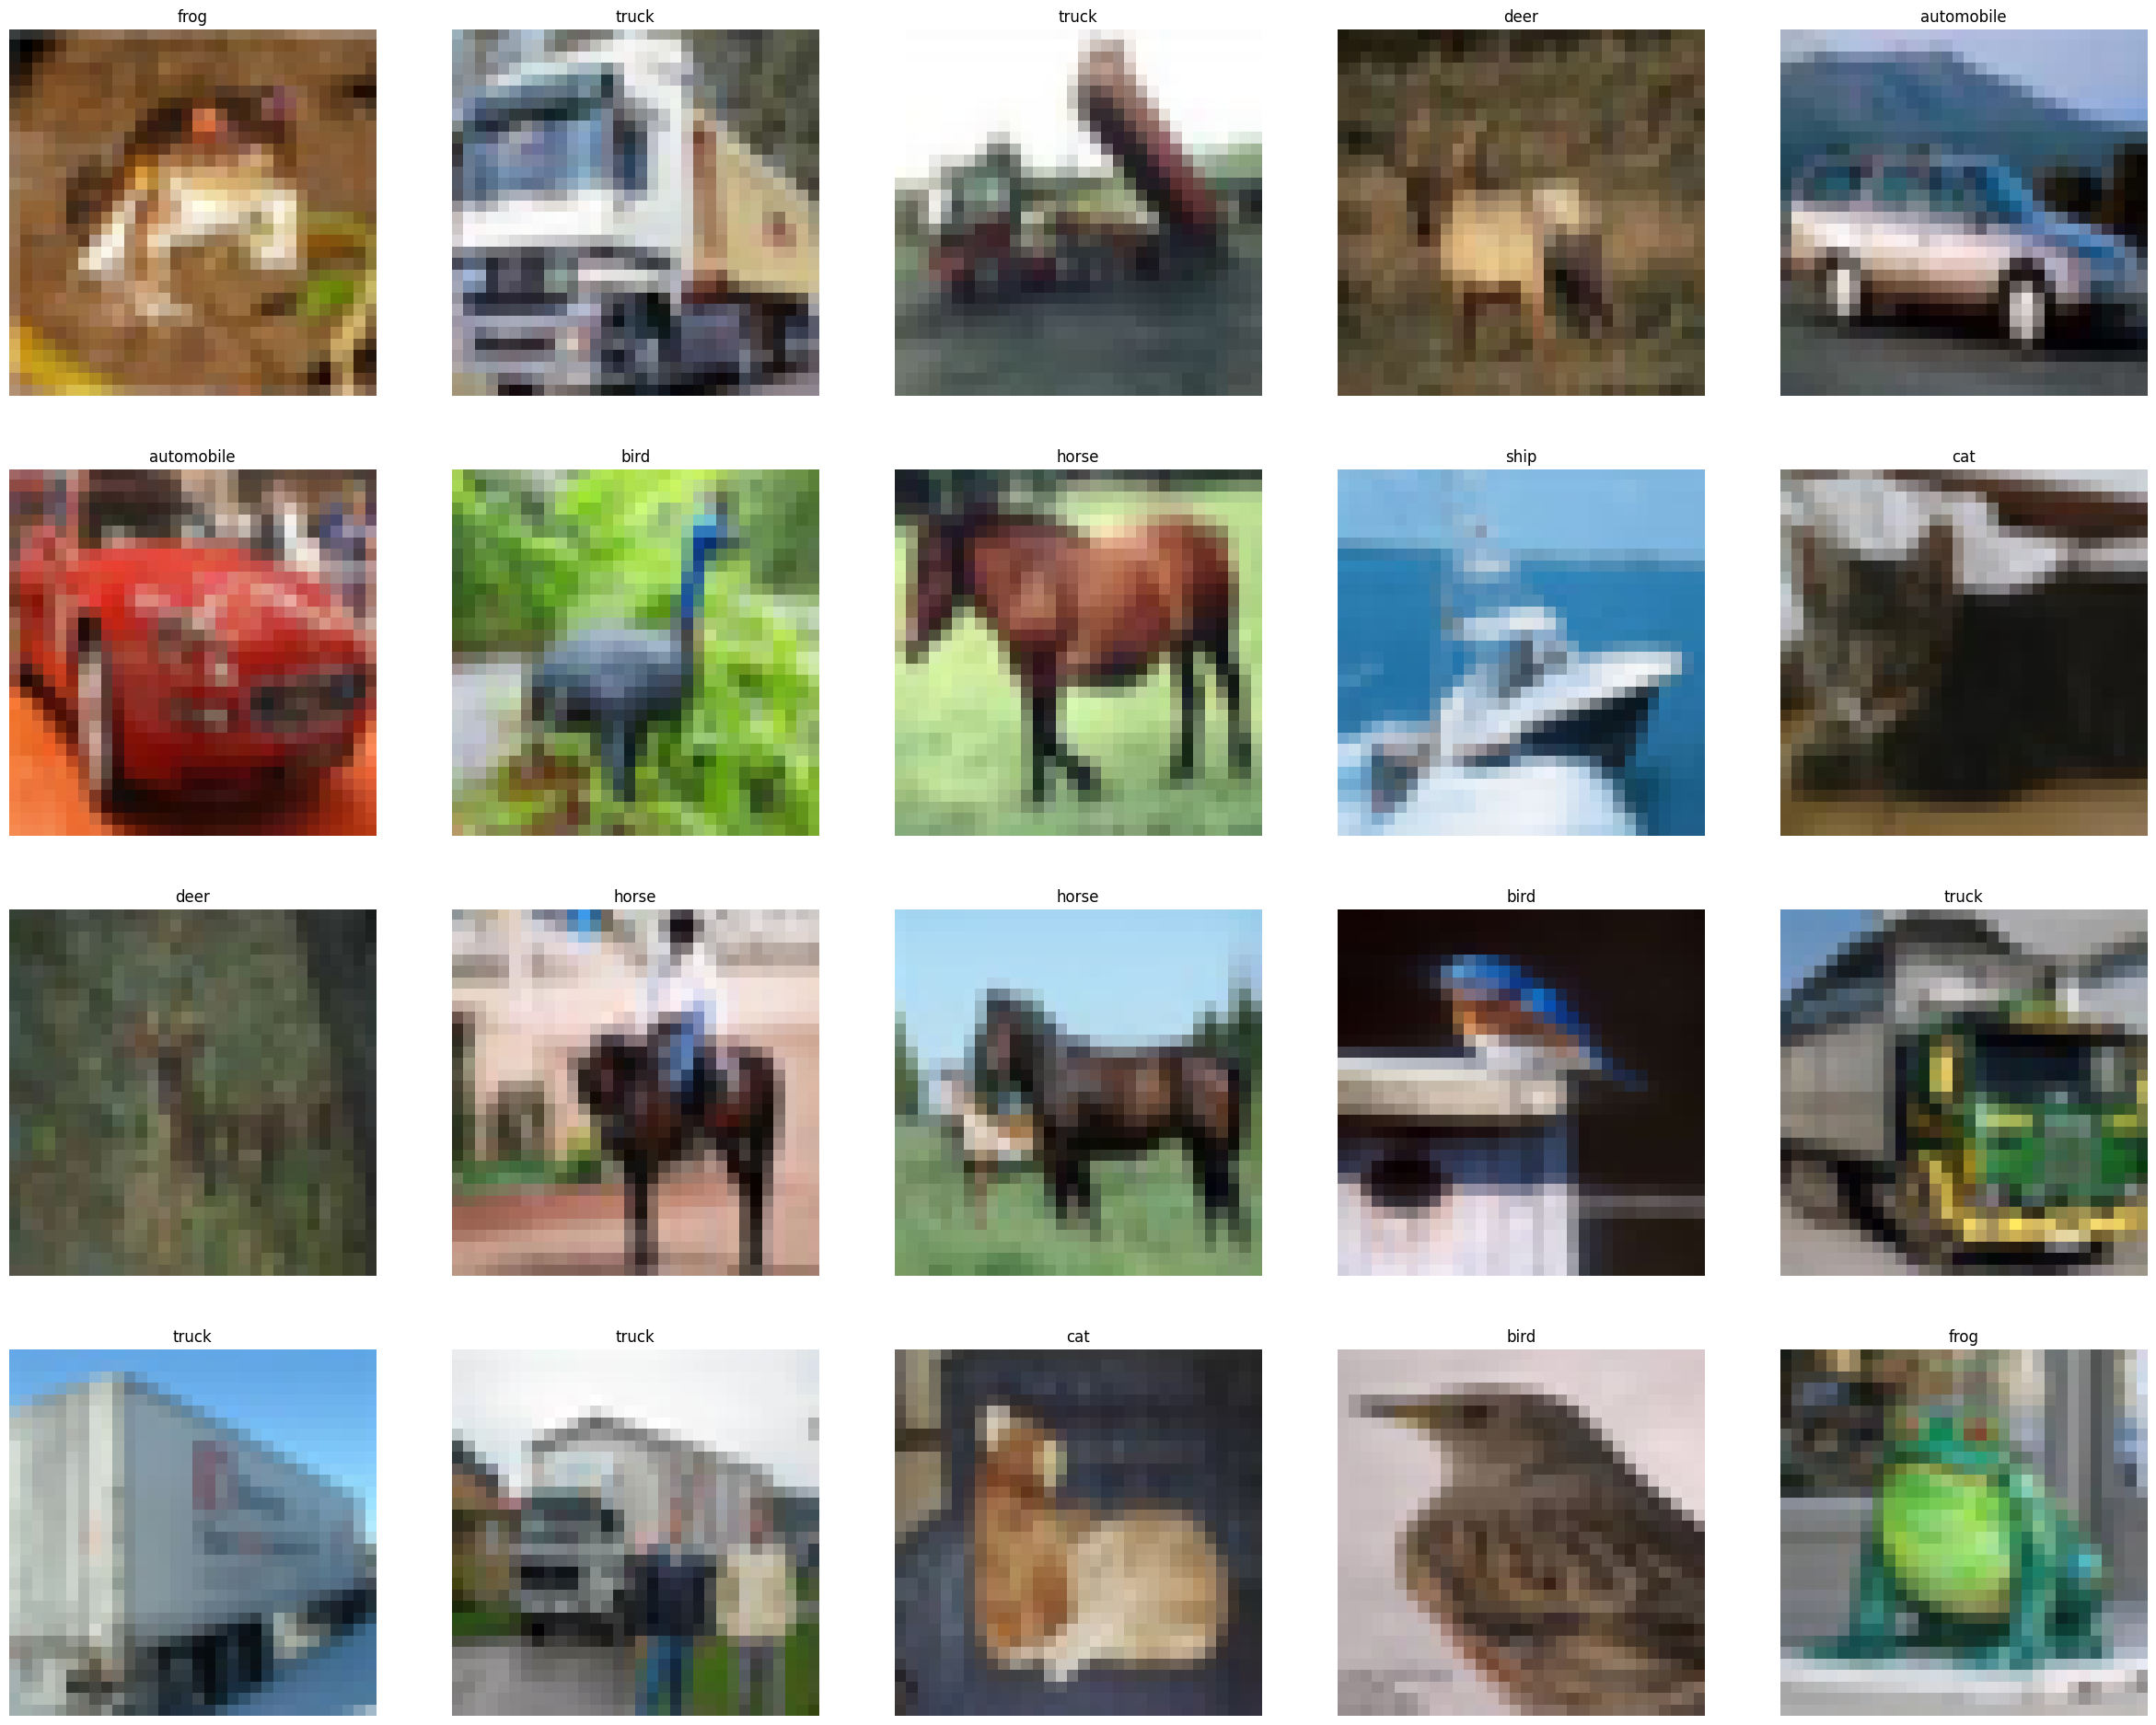

In [ ]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

Preprocessing functions

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

def zero_one_scaler(image):
    return image/255.0

def get_preprocessed_ohe(images, labels, pre_func=None):
    # preprocessing 함수가 입력되면 이를 이용하여 image array를 scaling 적용.
    if pre_func is not None:
        images = pre_func(images)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용.
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )

# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성.
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.2, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


In [ ]:
IMAGE_SIZE = 227
BATCH_SIZE = 64

from tensorflow.keras.utils import Sequence
import cv2
import sklearn

# 입력 인자 images_array labels는 모두 numpy array로 들어옴.
# 인자로 입력되는 images_array는 전체 32x32 image array임.
class CIFAR_Dataset(Sequence):
    def __init__(self, images_array, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        images_array: 원본 32x32 만큼의 image 배열값.
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당.
        # 인자로 입력되는 images_array는 전체 32x32 image array임.
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음.
            #self.on_epoch_end()
            pass

    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함.
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다.
        return int(np.ceil(len(self.labels) / self.batch_size))

    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환.
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄.
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        # 32x32 image array를 self.batch_size만큼 가져옴.
        images_fetch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행.
        # 변환된 image 배열값을 담을 image_batch 선언. image_batch 배열은 float32 로 설정.
        image_batch = np.zeros((images_fetch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')

        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음.
        for image_index in range(images_fetch.shape[0]):
            #image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            # 원본 image를 IMAGE_SIZE x IMAGE_SIZE 크기로 변환
            image = cv2.resize(images_fetch[image_index], (IMAGE_SIZE, IMAGE_SIZE))
            # 만약 augmentor가 주어졌다면 이를 적용.
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']

            # 만약 scaling 함수가 입력되었다면 이를 적용하여 scaling 수행.
            if self.pre_func is not None:
                image = self.pre_func(image)

            # image_batch에 순차적으로 변환된 image를 담음.
            image_batch[image_index] = image

        return image_batch, label_batch

    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨.
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 원본 image배열과 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)
        else:
            pass

def zero_one_scaler(image):
    return image/255.0



In [ ]:
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성.
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)


# Split data
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.2, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)


# Resize sequence dataset
tr_ds = CIFAR_Dataset(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=True, pre_func=zero_one_scaler)
val_ds = CIFAR_Dataset(val_images, val_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=zero_one_scaler)

print(next(iter(tr_ds))[0].shape, next(iter(val_ds))[0].shape)
print(next(iter(tr_ds))[1].shape, next(iter(val_ds))[1].shape)
print(next(iter(tr_ds))[0][0])

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)
(64, 227, 227, 3) (64, 227, 227, 3)
(64, 10) (64, 10)
[[[0.6431373  0.68235296 0.69411767]
  [0.6431373  0.68235296 0.69411767]
  [0.6431373  0.68235296 0.69411767]
  ...
  [0.27450982 0.28235295 0.26666668]
  [0.27450982 0.28235295 0.26666668]
  [0.27450982 0.28235295 0.26666668]]

 [[0.6431373  0.68235296 0.69411767]
  [0.6431373  0.68235296 0.69411767]
  [0.6431373  0.68235296 0.69411767]
  ...
  [0.27450982 0.28235295 0.26666668]
  [0.27450982 0.28235295 0.26666668]
  [0.27450982 0.28235295 0.26666668]]

 [[0.6431373  0.68235296 0.69411767]
  [0.6431373  0.68235296 0.69411767]
  [0.6431373  0.68235296 0.69411767]
  ...
  [0.27450982 0.28235295 0.26666668]
  [0.27450982 0.28235295 0.26666668]
  [0.27450982 0.28235295 0.26666668]]

 ...

 [[0.91764706 0.8627451  0.88235295]
  [0.91764706 0.8627451  0.88235295]
  [0.91764706 0.8627451

### Data Pipeline

An input/data pipeline is described as a series of functions or methods that are called consecutively one after another.

Input pipelines are a chain of functions that either act upon the data or enforces an operation on the data flowing through the pipeline.

### AlexNet Model Implementation

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras import regularizers

In [ ]:
def create_alexnet(in_shape=(227, 227, 3), n_classes=10, kernel_regular=None):
        # 첫번째 CNN->ReLU->MaxPool, kernel_size를 매우 크게 가져감(11, 11). 지금은 (11, 11) 사용하지 않음.
    input_tensor = Input(shape=in_shape)

    x = Conv2D(filters= 96, kernel_size=(11,11), strides=(4,4), padding='valid')(input_tensor)
    x = Activation('relu')(x)

    x = tf.nn.local_response_normalization(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

    # 두번째 CNN->ReLU->MaxPool. kernel_size=(5, 5)
    x = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same',kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = tf.nn.local_response_normalization(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

    # 3x3 Conv 2번 연속 적용. filters는 384개
    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = tf.nn.local_response_normalization(x)

    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = tf.nn.local_response_normalization(x)

    # 3x3 Conv를 적용하되 filters 수를 줄이고 maxpooling을 적용
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

    # Dense 연결을 위한 Flatten
    x = Flatten()(x)

    # Dense + Dropout을 연속 적용.
    x = Dense(units = 4096, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(units = 4096, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    # 마지막 softmax 층 적용.
    output = Dense(units = n_classes, activation = 'softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()

    return model


In [ ]:
# Create model with input 128x128x3
model = create_alexnet(in_shape=(227, 227, 3), n_classes=10, kernel_regular=regularizers.l2(l2=1e-4))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 tf.nn.local_response_norma  (None, 55, 55, 96)        0         
 lization (TFOpLambda)                                           
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(tr_ds, epochs=30,
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=val_ds,
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb]
                   )

Epoch 1/30
625/625 [==============================] - 183s 270ms/step - loss: 1.8486 - accuracy: 0.3556 - val_loss: 1.7444 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 168s 269ms/step - loss: 1.4867 - accuracy: 0.4767 - val_loss: 1.4347 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 166s 266ms/step - loss: 1.3162 - accuracy: 0.5385 - val_loss: 2.1401 - val_accuracy: 0.3861 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 170s 272ms/step - loss: 1.1886 - accuracy: 0.5853 - val_loss: 1.2302 - val_accuracy: 0.5669 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 166s 265ms/step - loss: 1.0976 - accuracy: 0.6151 - val_loss: 1.4439 - val_accuracy: 0.5163 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 166s 265ms/step - loss: 1.0354 - accuracy: 0.6405 - val_loss: 1.0721 - val_accuracy: 0.6252 - lr: 0.0010
Epoch 7/30
625/625 [==========================

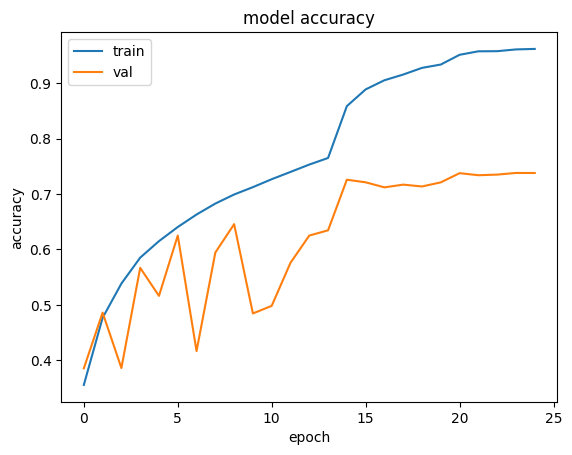

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

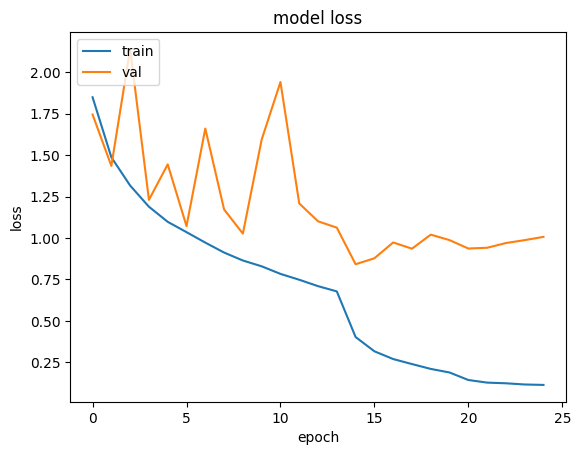

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()